# 02805 Social Graphs & Interactions Final Project
This notebook focuses on the network Analysis of the Spotify Artist Network generated by collaborations found in the Spotify #nowplaying dataset we scrapped from Twitter.

We analyze network statistics, correlations, word clouds and assimilate our findings to uncover the underlying interpretations of it within the context of a Spotify artist network.

In [1]:
# installing relevant packages
!pip install spotipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 631 kB/s 
     |████████████████████████████████| 140 kB 24.8 MB/s 
     |████████████████████████████████| 236 kB 26.9 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [4]:
# general imports
import math
import re
import csv
import os
import json
import pickle
import random
from collections import Counter, defaultdict
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# spotify api imports
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

# network building imports
import networkx as nx
from networkx.readwrite import json_graph
from community import community_louvain
import fa2
from wordcloud import WordCloud

In [3]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading in the data 
This includes:

1) The processed Spotify #nowplaying dataset, with data-preprocessing done as outlined in the report

2) The artists dataset with information from Spotify API

3) Spotify Artist Network generated using collaborations found in the final #nowplaying dataset


Load in the #nowplaying dataset

In [26]:
# load in the pickled dataframe
spotify_df = pd.read_pickle('/content/drive/MyDrive/University Materials/Business Analytics/Y3S1/02805 Social graphs & interactions/Data/Spotify Network/spotify_dataset_processed.pickle') 

In [27]:
spotify_df.head()

,user_id,artistname,trackname,genre,tracks,tracks_freq
0,9cc0cfd4d7d7885102480dd99e7a90d6,(elvis costello),(The Angels Wanna Wear My) Red Shoes,"[art rock, folk, folk rock, mellow gold, new w...","((The Angels Wanna Wear My) Red Shoes, (elvis ...",67
1,9cc0cfd4d7d7885102480dd99e7a90d6,(elvis costello),"(What's So Funny 'Bout) Peace, Love And Unders...","[art rock, folk, folk rock, mellow gold, new w...","((What's So Funny 'Bout) Peace, Love And Under...",75
3,9cc0cfd4d7d7885102480dd99e7a90d6,(elvis costello),Accidents Will Happen,"[art rock, folk, folk rock, mellow gold, new w...","(Accidents Will Happen, (elvis costello))",75
4,9cc0cfd4d7d7885102480dd99e7a90d6,(elvis costello),Alison,"[art rock, folk, folk rock, mellow gold, new w...","(Alison, (elvis costello))",186
5,9cc0cfd4d7d7885102480dd99e7a90d6,(lissie),All Be Okay,[folk-pop],"(All Be Okay, (lissie))",5


Load in the artists dataset

In [46]:
artists_df = pd.read_pickle('/content/drive/MyDrive/University Materials/Business Analytics/Y3S1/02805 Social graphs & interactions/Data/Spotify Network/artists_dataset.pickle') 

In [47]:
artists_df.head()

,artistname,id,popularity,genres,related_artists
0,z-trip,0YUefH6Li1IsJBtlUWgtwc,33,[turntablism],"[cut chemist, lyrics born, x-ecutioners, black..."
1,canton jones,3nzEXHMRFWTw4zt3pVRv6V,36,"[christian hip hop, gospel]","[james fortune, kierra sheard, fred hammond]"
3,meshell ndegeocello,0uZRjholJ0fVC2J9EvnYnj,46,[neo soul],"[les nubians, raphael saadiq, jill scott, leel..."
4,birdy,2WX2uTcsvV5OnS0inACecP,70,[pop],"[gabrielle aplin, emeli sandé, ella eyre]"
5,skid row,4opTS86dN9uO313J9CE8xg,61,"[album rock, glam metal, hard rock, metal, rock]","[cinderella, poison, quiet riot, twisted siste..."


Load in the network

In [5]:
with open('/content/drive/MyDrive/University Materials/Business Analytics/Y3S1/02805 Social graphs & interactions/Data/Spotify Network/artist_network_collaboration.json', 'r') as f:
    js_graph = json.load(f)
artists_graph = json_graph.node_link_graph(js_graph)

## Network Analysis 
We do some network analysis to answer some questions related to the artist's network statistics.

I'm running this on Google Colab, which comes with older versions of certain modules. I'll upgrade all of them as networkx has some dependency issues with other packages.

In [9]:
!pip install networkx --upgrade
!pip install scipy --upgrade # run this as nx.draw has dependencies on scipy coo_array attribute only available in 1.8.0 and above
!pip install matplotlib --upgrade # run this as axes bar_label attribute only available in 3.4 and above

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Plot the network

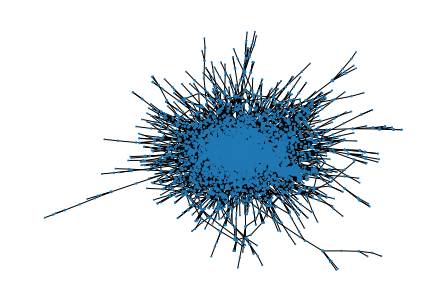

In [7]:
# plot the network using nx.draw
nx.draw(artists_graph, node_size=list(dict(artists_graph.degree()).values()))

### Nodes and Edges

Each node represents **a Spotify artist from the #nowplaying dataset**. If **there is a collaboration between two artists**, we include an edge between the two nodes representing the artists.

In [15]:
nx.number_of_nodes(artists_graph)

4238

In [16]:
nx.number_of_edges(artists_graph)

9067

### Density of Graph

The density of a graph represents the ratio between the edges present in the graph and the maximum number of edges that a graph can contain.
Conceptually, this gives us an idea of how dense our artist graph is in terms of edge connectivity.

In [8]:
nx.density(artists_graph)

0.0010098902865083358

We observe that the density of the graph is very low, which tells us that the artists graph is not very dense ie. artists don't really collaborate as much as they could. This makes sense as an artist is likely to be selective with picking their collaborators as not all genres are able to mesh well with each other. The selective and intentional nature of collaboration would hence lead to a low artist network graph density.

### Degree distribution
Since a node is an artist and an edge is present if there is a collaboration between two artists, the degree of the nodes represents the **number of collaborations** an artist has with other artists.

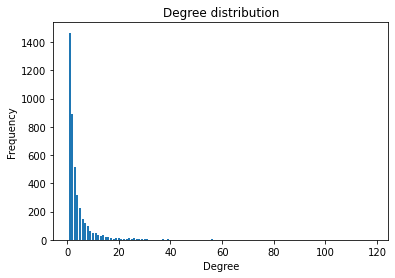

In [18]:
# Plot degree distribution
degree = list(dict(artists_graph.degree()).values())
hist, bin = np.histogram(degree, bins=range(min(degree), max(degree))) # return an array with histogram values and the bin edges 

# f, ax = plt.subplots(1, 2, figsize=(15,5))
plt.title('Degree distribution')
plt.bar(bin[:-1], hist)
plt.xlabel("Degree")
plt.ylabel("Frequency")

plt.show()

Here, we observe that most of the nodes have low degrees, some of them have a moderate degree, and a few nodes that have very high degrees. This means that most of the artists have few collaborations, while some artists have a higher number of collaborations, and a few artists have many collaborations (hubs).

We also investigate the mean, median, mode, maximum and minimum degrees.

In [10]:
# churn out a pandas dataframe that gives us information on the various summary statistics of degrees in the network
graph_degree_statistics = pd.DataFrame([[np.mean(degree), np.median(degree), stats.mode(degree)[0][0], max(degree), min(degree)]],
                                       columns='Mean Degree,Median Degree,Mode Degree,Maximum Degree,Minimum Degree'.split(','))
graph_degree_statistics

,Mean Degree,Median Degree,Mode Degree,Maximum Degree,Minimum Degree
0,4.278905,2.0,1,120,1


In [11]:
# find which artist has the highest degree ie. most number of collaborations
sorted(artists_graph.degree, key=lambda x: x[1], reverse=True)[0]

('his orchestra', 120)

We observe that the mean degree is around 4.28, which indicates that on average, each artist has about 4 collaborations. This might not be the best metric to look at as we have outliers (hubs that have a very high degree/no. of collaborations that tend to skew the mean to higher values).

We also analyze the median degree, which tells us that at the 50th percentile, artists have about 2 collaborations. 

The most prominent number of collaborations is 1, meaning that most artists have one collaboration only.

We can also see that there is one artist with 120 collaborations. Out of curiosity, we take a look at who this artist is.

Looks like 'His Orchestra' is the artist with the most number of collaborations.

Finally, we see that the minimum number of collaborations is 1, which is expected as we removed all the isolated nodes in our pre-processing ie. the artists with no collaborations.

### Check if distribution obeys a power law
Here, we check if the degree distribution of the artist network obeys a power law. We are essentially checking if the artist network is a scale-free network.

A scale-free network is a network whose degree distribution follows a power law.
This means that the *logarithm of the probability of a node having a certain degree k* depends linearly on *the logarithm of degree k*, and the slope of a line representing the relationship is the power law coefficient γ.

When the power law coefficient γ is high, the number of nodes with high degree is snaller than the number of nodes with low degree.

A high value of γ represents a network in which the distribution of edges is fairer.

In [12]:
# installing relevant packages
!pip install powerlaw

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Calculating best minimal value for power law fit
The slope of the incoming degree distribution 3.597517997056107


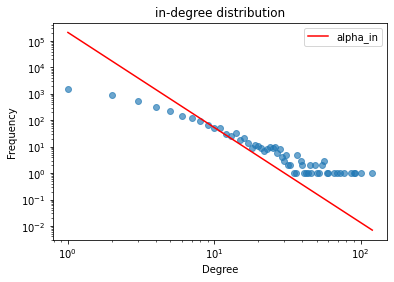

In [13]:
from math import exp
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import powerlaw

degree_sequence = sorted(list(dict(artists_graph.degree()).values()), reverse=True)
alpha_in = powerlaw.Fit(degree_sequence).alpha
print("The slope of the incoming degree distribution", alpha_in)
degree_freq = Counter(degree_sequence)

x = np.log(np.array(list(degree_freq.keys())))
y = np.log(np.array(list(degree_freq.values())))

ymin, ymax = ([0, y.max()])
ymid = (ymin + ymax) / 2
xmin, xmax = ([0, x.max()])
xmid = (xmin + xmax) / 2

y1 = -alpha_in * (xmin - xmid) + ymid
y2 = -alpha_in * (xmax - xmid) + ymid

fig = plt.figure()
ax = plt.gca()
plt.scatter(degree_freq.keys(), degree_freq.values() , alpha=0.65)
ax.plot(np.exp([xmin, xmax]), np.exp([y1, y2]), 'r', label="alpha_in")

plt.title("in-degree distribution")
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.loglog()
plt.legend()

Here, we observe that the artist network's degree distribution does indeed obey a power law. In other words, the artist network is a scale-free network.

The power law coefficient we obtained from our analysis is about 3.60.

Hence, the artist network follows the *small world regime* since degree exponent γ is greater than 3.

This means that the second moment of the degree, variance, is finite. Inherently, this tells us that the spread in terms of collaborations between artists is quantifiable and does not diverge.

The average distance between the artists also follows the *small world result* that's derived for random networks.

For scale-free networks where γ > 3, hubs continue to be present (as seen from some artists that have many collaborations). However, they are not sufficiently large and numerous to have a significant impact on the distance between the nodes.

This means that the distances between each artist in the network is larger compared to a network with a smaller degree exponent γ.

### Finding communities within the best partition
Here, we find the best partition that separates the network into groups or communities.

We then find the modularity of the best partition, and inspect the communities to derive meaningful insights.

In [6]:
from community import community_louvain
# compute the best partition
communities = community_louvain.best_partition(artists_graph, random_state=0) 
# we used random_state parameter so that the results can be reproduced
mod = community_louvain.modularity(communities, artists_graph)
print("modularity is", mod)

no_communities = len(Counter(communities.values()))
print("The Louvain algorithm had found", no_communities, "communities")

for community, count in Counter(communities.values()).most_common():
    print("The community", community, "has", count, "nodes")

modularity is 0.7246005737783654
The Louvain algorithm had found 49 communities
The community 8 has 632 nodes
The community 10 has 400 nodes
The community 7 has 333 nodes
The community 1 has 310 nodes
The community 0 has 168 nodes
The community 6 has 159 nodes
The community 5 has 152 nodes
The community 2 has 148 nodes
The community 27 has 139 nodes
The community 3 has 128 nodes
The community 13 has 121 nodes
The community 11 has 115 nodes
The community 4 has 112 nodes
The community 18 has 96 nodes
The community 35 has 95 nodes
The community 9 has 92 nodes
The community 16 has 91 nodes
The community 20 has 91 nodes
The community 21 has 81 nodes
The community 29 has 76 nodes
The community 15 has 67 nodes
The community 17 has 65 nodes
The community 14 has 61 nodes
The community 19 has 57 nodes
The community 33 has 53 nodes
The community 25 has 51 nodes
The community 30 has 50 nodes
The community 28 has 48 nodes
The community 31 has 48 nodes
The community 38 has 46 nodes
The community 34 

We obtained a high modularity score of 0.725 for the best partition.

Modularity measures the strength of division of a network into communities, where a higher modularity implies better partition. Since we are computing the modularity score of the best partition, we are obtaining the maximum modularity.

Networks with high modularity have dense connections between the nodes within communities but sparse connections between nodes in different communities.

As such, we can conclude that the artist network is well-separated into various distinct communities where each community is made up of different artists that have collaborated extensively with other artists in that community.

We plot a barplot that shows us the number of artists in each community.





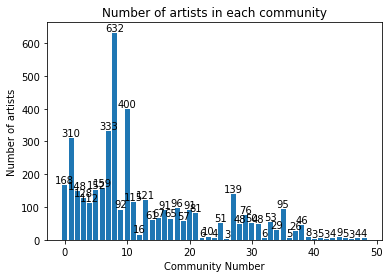

In [7]:
# get the count of artists in each community
count_artists_community = list(Counter(communities.values()).values())
# get the community number
community_no = list(Counter(communities.values()).keys())
fig, ax = plt.subplots()

p = ax.bar(community_no, count_artists_community)

ax.axhline(0, color='grey', linewidth=0.8)
ax.set_ylabel('Number of artists')
ax.set_xlabel('Community Number')
ax.set_title('Number of artists in each community')
ax.bar_label(p)

plt.show()

### Plot the network using ForceAtlas2
- We color the different communities differently to show the modularity of the network.
- We also display each node differently depending on the degree of each node.

100%|██████████| 2000/2000 [02:48<00:00, 11.84it/s]


BarnesHut Approximation  took  64.64  seconds
Repulsion forces  took  95.43  seconds
Gravitational forces  took  0.13  seconds
Attraction forces  took  0.39  seconds
AdjustSpeedAndApplyForces step  took  2.32  seconds


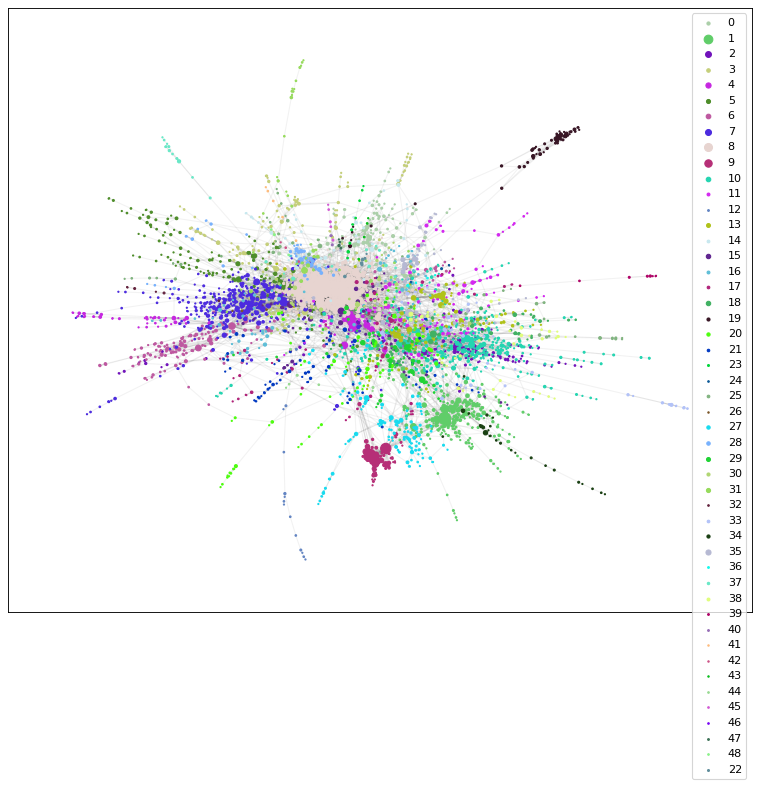

In [8]:
forceatlas2 = fa2.ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        edgeWeightInfluence=0,

                        # Performance
                        jitterTolerance=0.9,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,

                        # Tuning
                        scalingRatio=0.1,
                        strongGravityMode=True,
                        gravity=0.6,

                        # Log
                        verbose=True)
positions = forceatlas2.forceatlas2_networkx_layout(artists_graph, pos=None, iterations=2000)
        
plt.figure(figsize=(12, 10), dpi=80)
communities_color = {} # keep a dict with colors for each community
nodelist_dc = []

for community in  Counter(communities.values()):
    communities_color[community] = np.array([random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1)])
    nodelist = []
    
    for node in artists_graph:
        if node not in communities:
            nodelist_dc.append(node)
        elif communities[node] == community:
            nodelist.append(node)
    # display nodes from current artist community      
    nx.draw_networkx_nodes(artists_graph,
                           pos=positions,
                           nodelist=nodelist,
                           node_size=list(dict(artists_graph.degree(nodelist)).values()),
                           node_color=communities_color[community].reshape(1,-1), label=community)
nx.draw_networkx_edges(artists_graph, pos=positions, alpha=0.05)
plt.legend()

### Clustering Coefficient
Clustering coefficient is a measure of the degree to which nodes in a graph tend to cluster together.

Here, we examine the clustering coefficients of the artists in the artist network.

We first plot the distribution of the clustering coefficients across all the artists.

Then, we take a look at some of the summary statistics for the clustering coefficients.

In [9]:
# obtain clustering coefficient of all the nodes/artists in the network
clustering_coeff = nx.clustering(artists_graph)

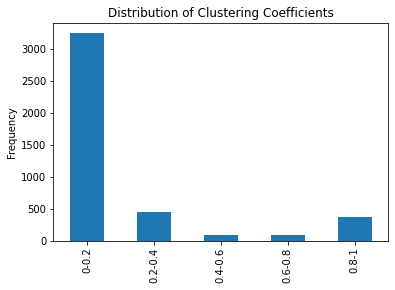

In [10]:
# plot the distribution of the clustering coefficients across all the artists
# first, we have to do binning since clustering coefficients are continuous values
bins = [0, 0.2, 0.4, 0.6, 0.8, 1]
labels = ['0-0.2', '0.2-0.4', '0.4-0.6', '0.6-0.8', '0.8-1']
fig, ax = plt.subplots()

pd.cut(list(clustering_coeff.values()), bins=bins, labels=labels, include_lowest=True).value_counts().plot(kind='bar')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Clustering Coefficients')

plt.show()

We observe that majority of the artists have a clustering coefficient within 0 and 0.2. This is undoubtedly a result of most of the artists having a clustering coefficient of 0. This means that the collaborators of these artists are not linked to each other at all.

On the contrary, we can see that there is a sizeable chunk of artists with clustering coefficient ranging from 0.8 - 1. This means that these artists are collaborating with other artists that are also likely collaborating with each other.

In [11]:
# churn out a pandas dataframe that gives us information on the various summary statistics of clustering coefficients in the network
clustering_coeff_values = list(clustering_coeff.values())
graph_clustering_coeff_statistics = pd.DataFrame([[np.mean(clustering_coeff_values), np.median(clustering_coeff_values), 
                                                  stats.mode(clustering_coeff_values)[0][0], max(clustering_coeff_values), min(clustering_coeff_values)]],
                                                  columns='Mean Clustering Coefficient,Median Clustering Coefficient,Mode Clustering Coefficient,Maximum Clustering Coefficient,Minimum Clustering Coefficient'.split(','))
graph_clustering_coeff_statistics

,Mean Clustering Coefficient,Median Clustering Coefficient,Mode Clustering Coefficient,Maximum Clustering Coefficient,Minimum Clustering Coefficient
0,0.165733,0.0,0.0,1.0,0


From this set of summary statistics, we can see that the average clustering coefficient is only 0.17. 

This means that on average, artists within the network tend to collaborate with artists that do not collaborate with each other. This finding measures up with the hypothesis that artists tend to be selective about their collaborations, choosing not to collaborate with many artists even if they have had mutual collaborations.

### Computing clustering coefficient within communities

In [12]:
# create a dataframe that stores clustering coefficient of an artist and community they belong to
cc_community_df = pd.DataFrame(index=communities.keys(), columns=['Clustering Coefficient', 'Community'])
for i in cc_community_df.index:
  cc_community_df.loc[i, :] = [clustering_coeff[i], communities[i]]
# display first 5 rows of the dataframe
cc_community_df.head()

,Clustering Coefficient,Community
krooked,0.666667,0
edo de waart,0,1
sizzla,0.1,2
björk,0,3
mana,0,4


Now, we take a closer look at the clustering coefficients of each individual community. 

We inspect the top 5 communities by average clustering coefficient.

In [13]:
# get the top 5 communities by average clustering coefficient
top_5_communities_cc = cc_community_df.groupby('Community').mean().sort_values(by='Clustering Coefficient', ascending=False)[:10]
top_5_communities_cc

,Clustering Coefficient
Community,
40,0.777778
9,0.496728
22,0.450000
47,0.375000
45,0.333333


To visualize our findings better, we plot the boxplot that details the summary statistics of the clustering coefficient for each of the top 5 communities via average clustering coefficient.

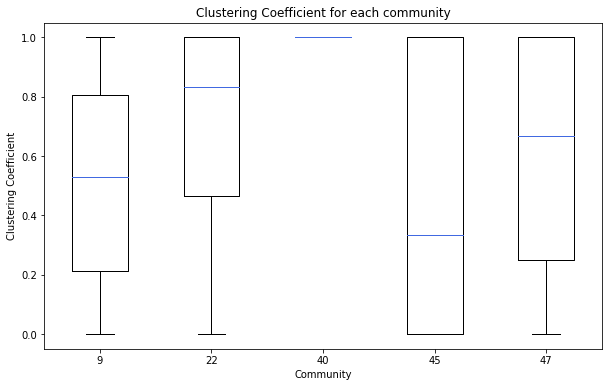

In [14]:
# split nodes in communities
community_split_cc = defaultdict(list)
for key, val in sorted(communities.items()):
    # get top 5 communities via average clustering coefficient
    if val in top_5_communities_cc.index:
      community_split_cc[val].append(key)
# dictionary of community : list of artists in that community for the top 5
# communities via average clustering coefficient
community_split_cc = dict(sorted(community_split_cc.items()))
# clustering coefficient for each community:
clustering_coeff_comm = {}
for key, values in community_split_cc.items():
    clustering_coeff_comm[key] = list(nx.clustering(artists_graph.subgraph(values)).values())
clustering_coeff_comm = dict(sorted(clustering_coeff_comm.items()))
fig, ax = plt.subplots(figsize=(10,6))
ax.boxplot(clustering_coeff_comm.values(),
           medianprops=dict(color='royalblue'))

ax.set_xticklabels(clustering_coeff_comm.keys())
ax.set_ylabel('Clustering Coefficient')
ax.set_xlabel('Community')
ax.set_title('Clustering Coefficient for each community')

plt.show()

Next, we inspect the top 5 communities by size.

In [15]:
# get the top 5 communities by size
top_5_communities_size = cc_community_df.groupby('Community').count().sort_values(by='Clustering Coefficient', ascending=False)[:5]
top_5_communities_size

,Clustering Coefficient
Community,
8,632
10,400
7,333
1,310
0,168


Likewise, we plot the boxplot that details the summary statistics of the clustering coefficient for each of the top 5 communities via size.

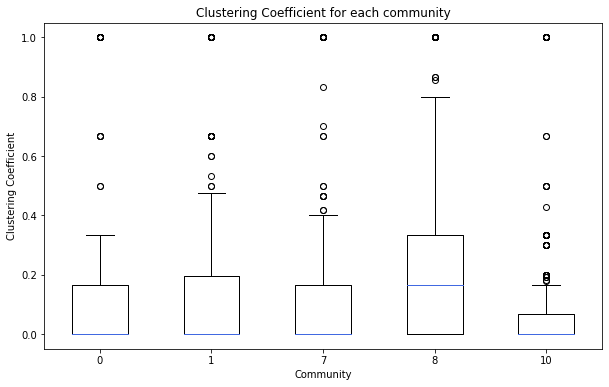

In [16]:
# split nodes in communities
community_split_size = defaultdict(list)
for key, val in sorted(communities.items()):
    # get top 5 communities via size
    if val in top_5_communities_size.index:
      community_split_size[val].append(key)
# dictionary of community : list of artists in that community for top 5 communities
# via size
community_split_size = dict(sorted(community_split_size.items()))
# clustering coefficient for each community:
clustering_coeff_comm = {}
for key, values in community_split_size.items():
    clustering_coeff_comm[key] = list(nx.clustering(artists_graph.subgraph(values)).values())
clustering_coeff_comm = dict(sorted(clustering_coeff_comm.items()))
fig, ax = plt.subplots(figsize=(10,6))
ax.boxplot(clustering_coeff_comm.values(),
           medianprops=dict(color='royalblue'))

ax.set_xticklabels(clustering_coeff_comm.keys())
ax.set_ylabel('Clustering Coefficient')
ax.set_xlabel('Community')
ax.set_title('Clustering Coefficient for each community')

plt.show()

When we compare the top 5 communities via average clustering coefficient and the top 5 communities via size, we observe that in general, the top 5 communities via clustering coefficient has higher median clustering coefficient than the top 5 communities via size. 

Unsurprisingly, this means that there are more collaborations within communities of artists where the artists' collaborators end up collaborating with each other, as compared to communities that have larger sizes.

### Correlation between clustering coefficient and degree

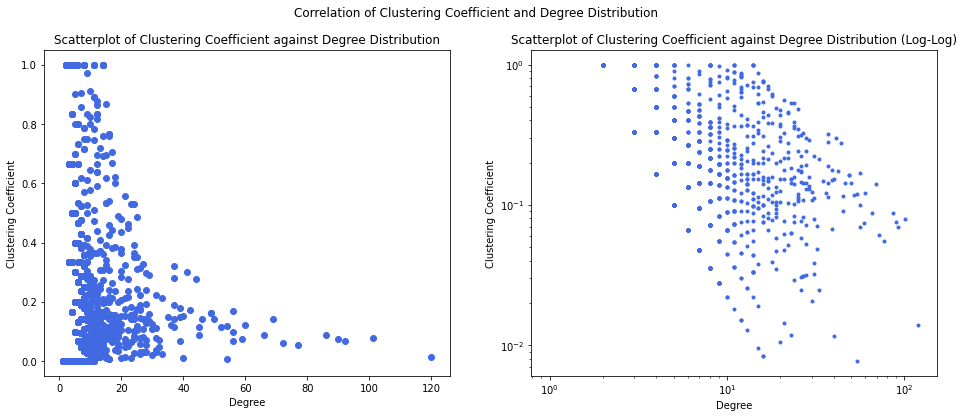

In [19]:
# Plot clustering coefficient vs degree distribution

fig, ax = plt.subplots(1,2, figsize=(16,6))
fig.suptitle("Correlation of Clustering Coefficient and Degree Distribution")
ax[0].scatter(degree, clustering_coeff_values, color='royalblue')
ax[0].set_xlabel("Degree")
ax[0].set_ylabel("Clustering Coefficient")
ax[0].set_title("Scatterplot of Clustering Coefficient against Degree Distribution")

ax[1].loglog(degree, clustering_coeff_values,'.', color='royalblue')
ax[1].set_xlabel('Degree')
ax[1].set_ylabel("Clustering Coefficient")
ax[1].set_title("Scatterplot of Clustering Coefficient against Degree Distribution (Log-Log)")

plt.show()

We observe that if a node has a higher degree, its neighbors become more sparsely connected with each other.

This means the artists that have a lot of collaborations are collaborating with artists that do not collaborate amongst each other.

This is unsurprising as hubs (artists with lots of collaborations) may be linked to mostly nodes with low degree (artists with a few collaborations).

### Centrality measures: Betweenness Centrality
We opt to use betweenness centrality as it determines the importance of artists based on the number of times they occur within the shortest paths between other nodes.

In [20]:
# get betweenness centrality of each artist
betweenness_centrality = nx.betweenness_centrality(artists_graph)
# sort the betweenness centrality
betweenness_centrality = dict(sorted(betweenness_centrality.items()))

In [21]:
# average betweenness centrality for the entire artist network
np.mean(list(betweenness_centrality.values()))

0.0012194396814830329

We see that the average betweenness centrality for the entire artist network is only 0.00122. This means that most of the artists are not in the shortest paths between artists. This is expected given the large size of the scale-free network.

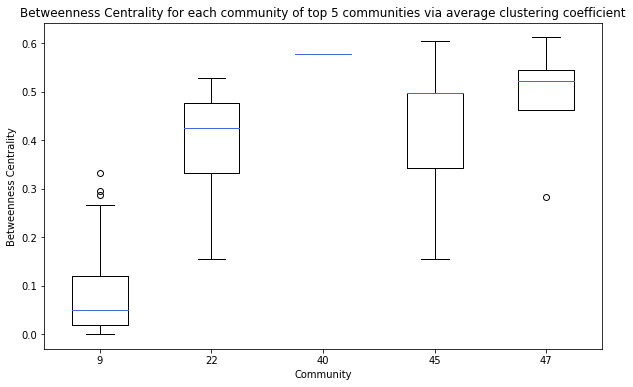

In [22]:
# betweenness centrality for each community of the top 5 via average clustering coefficient
betweenness_centrality_comm = {}
for key, values in community_split_cc.items():
    betweenness_centrality_comm[key] = list(nx.eigenvector_centrality(artists_graph.subgraph(values), max_iter=1000).values())
betweenness_centrality_comm = dict(sorted(betweenness_centrality_comm.items()))
fig, ax = plt.subplots(figsize=(10,6))

ax.boxplot(betweenness_centrality_comm.values(), medianprops=dict(color='royalblue'))
ax.set_xticklabels(betweenness_centrality_comm.keys())
ax.set_ylabel('Betweenness Centrality')
ax.set_xlabel('Community')
ax.set_title('Betweenness Centrality for each community of top 5 communities via average clustering coefficient')

plt.show()

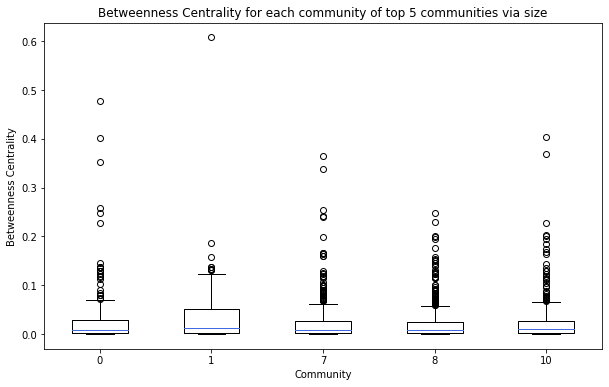

In [23]:
# betweenness centrality for each community of the top 5 via size
betweenness_centrality_comm = {}
for key, values in community_split_size.items():
    betweenness_centrality_comm[key] = list(nx.eigenvector_centrality(artists_graph.subgraph(values), max_iter=1000).values())
betweenness_centrality_comm = dict(sorted(betweenness_centrality_comm.items()))
fig, ax = plt.subplots(figsize=(10,6))

ax.boxplot(betweenness_centrality_comm.values(), medianprops=dict(color='royalblue'))
ax.set_xticklabels(betweenness_centrality_comm.keys())
ax.set_ylabel('Betweenness Centrality')
ax.set_xlabel('Community')
ax.set_title('Betweenness Centrality for each community of top 5 communities via size')

plt.show()

We observe that the betweenness centrality for top 5 communities via average clustering coefficient are generally significantly higher than the average betweenness centrality for the entire artist network.

For the top 5 communities via size, the betweenness centralities for each one of the communities are closer to the global betweenness centrality. 

### Correlation between centrality and degree distribution

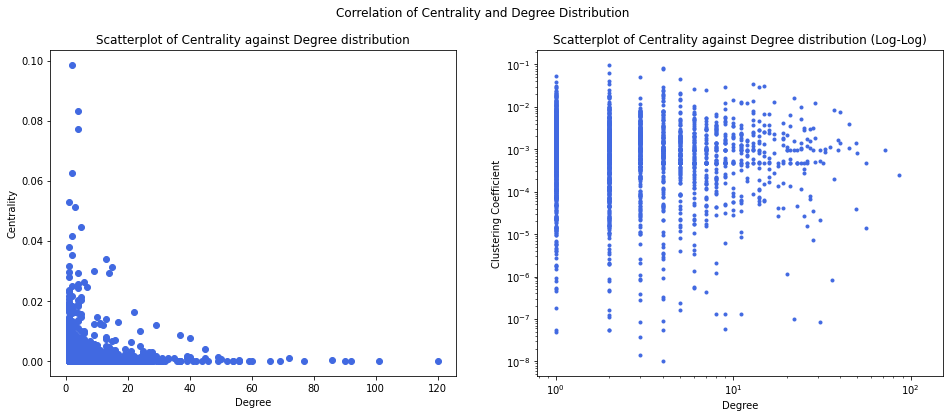

In [24]:
# Plot centrality and degree distribution

fig, ax = plt.subplots(1,2, figsize=(16,6))
fig.suptitle("Correlation of Centrality and Degree Distribution")
ax[0].scatter(degree, betweenness_centrality.values(), color='royalblue')
ax[0].set_xlabel("Degree")
ax[0].set_ylabel("Centrality")
ax[0].set_title("Scatterplot of Centrality against Degree distribution")

ax[1].loglog(degree, list(betweenness_centrality.values()), '.', color='royalblue')
ax[1].set_xlabel('Degree')
ax[1].set_ylabel("Clustering Coefficient")
ax[1].set_title("Scatterplot of Centrality against Degree distribution (Log-Log)")

plt.show()

### Word Clouds of Communities
We use TF scores to determine the importance of each artist within the community. We get the term frequency of each artist in each community in the #nowplaying dataset. Then, we plot the word clouds to see which artists are the most frequent in each one of the top 5 communities.

First, we obtain the popularity (no. of occurrences of an artist) of each artist in the #nowplaying Spotify dataset again.

In [28]:
popularity = Counter(x for xs in spotify_df.artistname for x in set(xs))

In [29]:
popularity.most_common()[:5]

[('daft punk', 31442),
 ('coldplay', 30414),
 ('radiohead', 27565),
 ('the rolling stones', 27134),
 ('eminem', 25813)]

Create a function to plot the word cloud

In [30]:
# Plot word cloud
def plot_word_cloud(document, title):
    wc = WordCloud(
            background_color="white", 
            max_words=4000, contour_width=3, 
            contour_color='steelblue', 
            collocations=False
        ).generate(document)

    plt.figure(figsize=[8,4])
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

Plot the artist name word clouds of top 5 communities via average clustering coefficient

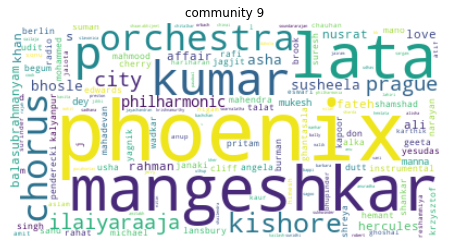

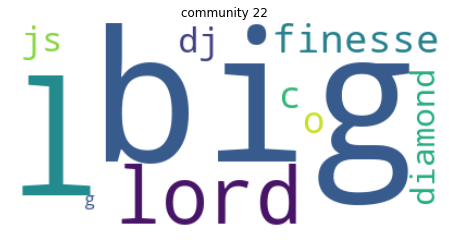

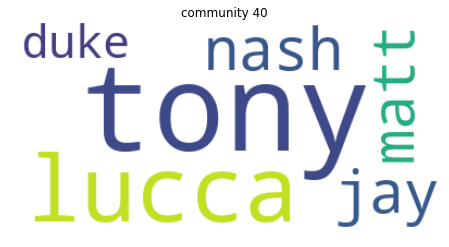

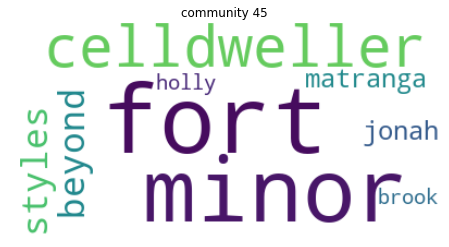

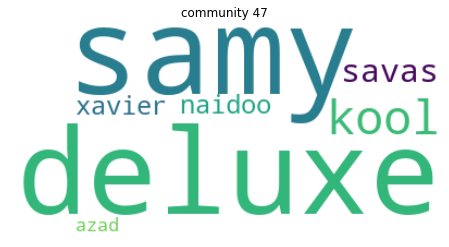

In [31]:
community_words_cc = {}
for community, artists in community_split_cc.items():
  words = ''
  for artist in artists:
    words += (popularity[artist] * (' ' + artist))
  community_words_cc[community] = words

for community in community_words_cc.keys():
  plot_word_cloud(community_words_cc[community], 'community ' + f'{community}')

We can see that the top 5 communities via average clustering coefficient had artists like Green Day & Madonna in Community 13. 

This means that within communities where artists collaborate more often than in others, some of the more popular artists are Green Day, Madonna, etc.

Plot the genre word clouds of top 5 communities via average clustering coefficient

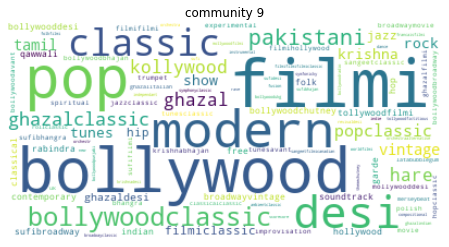

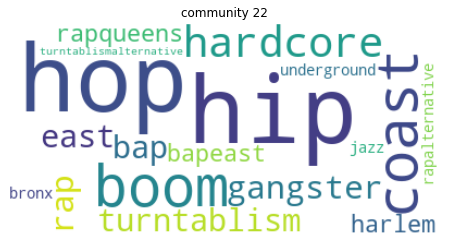

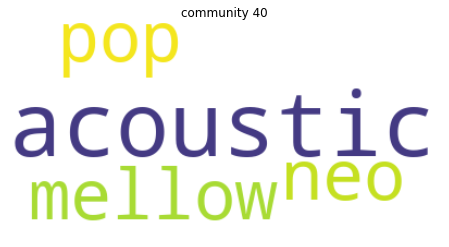

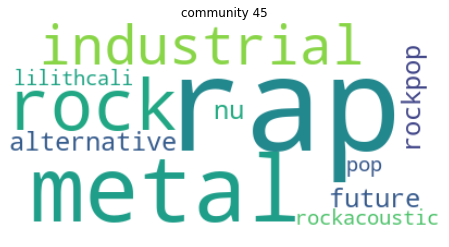

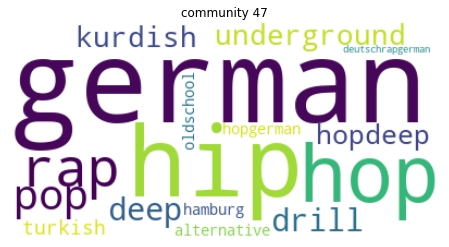

In [60]:
community_genres_cc = {}
for community, artists in community_split_cc.items():
  genres = ''
  for artist in artists:
    genres += " ".join(list(artists_df[artists_df['artistname'] == artist]['genres'])[0])
  community_genres_cc[community] = genres

for community in community_genres_cc.keys():
  plot_word_cloud(community_genres_cc[community], 'community ' + f'{community}')

We can see these communities with the highest average clustering coefficients (meaning artists in this network collaborate with artists that collaborate with each other often) are based on genres like Bollywood, hip-hop, acoustic and so on.

Plot the artist name word clouds of top 5 communities via size

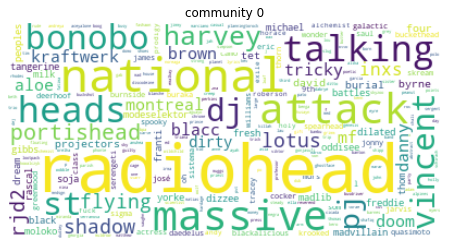

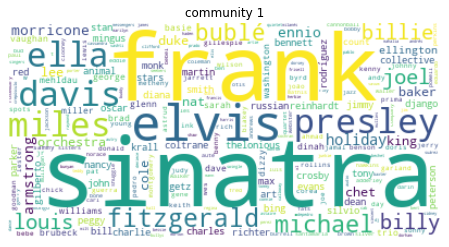

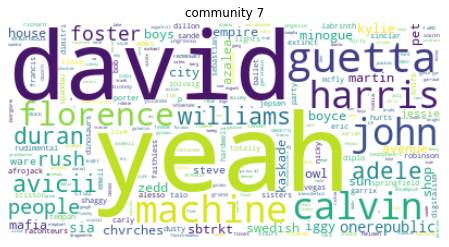

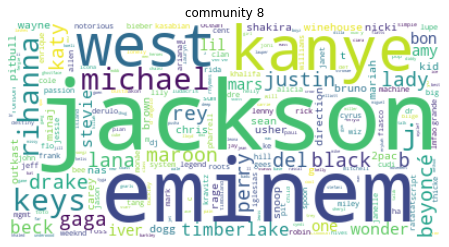

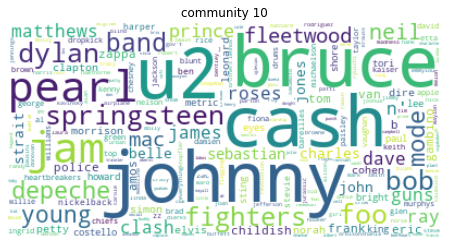

In [32]:
community_words_size = {}
for community, artists in community_split_size.items():
  words = ''
  for artist in artists:
    words += (popularity[artist] * (' ' + artist))
  community_words_size[community] = words

for community in community_words_size.keys():
  plot_word_cloud(community_words_size[community], 'community ' + f'{community}')

We can see that the top 5 communities via size had artists like Kanye West and Frank Sinatra being very popular amongst listeners. These artists have one thing in common, they've all been around for quite some time (although Frank Sinatra has admittedly been around much longer than Kanye West) and are globally recognized. As such, it is unsurprising that these artists are the most prevalent in these large communities.

Plot the genre word clouds of top 5 communities via size

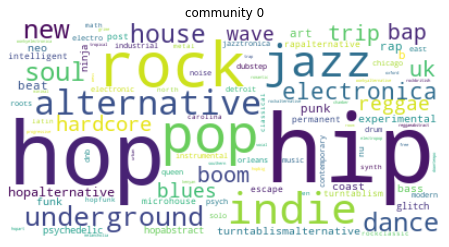

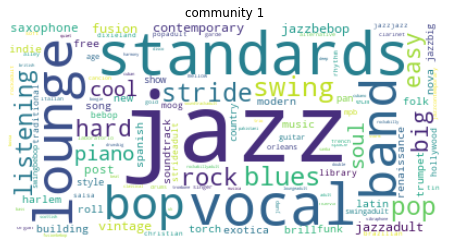

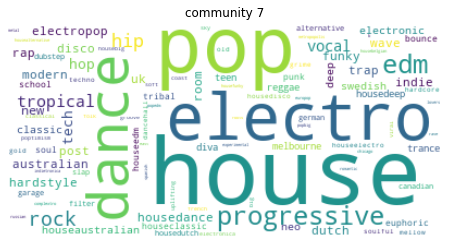

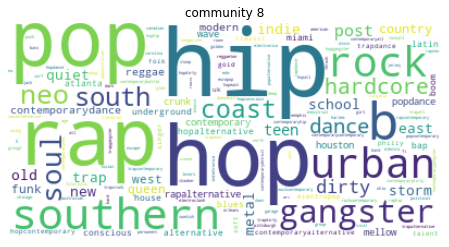

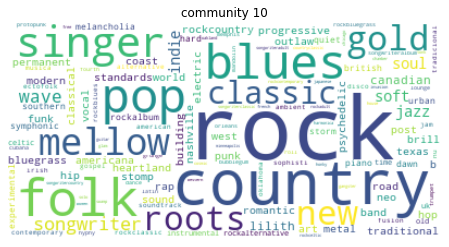

In [59]:
community_genres_size = {}
for community, artists in community_split_size.items():
  genres = ''
  for artist in artists:
    genres += " ".join(list(artists_df[artists_df['artistname'] == artist]['genres'])[0])
  community_genres_size[community] = genres

for community in community_genres_size.keys():
  plot_word_cloud(community_genres_size[community], 'community ' + f'{community}')

For the top communities via size (contains the most artists), we can see that the popular genres, jazz, electro, house, hip-hop, and rock are prevalent.

### Let us now answer some interesting questions related to the network and the dataset we pre-processed earlier.

*Q: Do people listen to artists that collaborate with other artists more?*

Artists tend to collaborate with other artists. Not only do they get to try their hand at new genres, but they also massively increase their reach towards new audiences.

To answer this, we check if the artist's popularity (no. of occurrences in the dataset) and the artist's degree of distribution are correlated.

In [33]:
# get the popularity of each artist from artist network
popularity = Counter(x for xs in spotify_df.artistname for x in set(xs)) # original popularity 
popularity_dict = {}
for artist in set(artists_graph.nodes):
  popularity_dict[artist] = popularity[artist]

In [34]:
# get the degree of each artist in the network
degree_dict = dict(artists_graph.degree)

In [35]:
# combine results into a dataframe for clear manipulation
popularity_degree_df = pd.DataFrame(index=popularity_dict.keys(), columns=['popularity', 'degree', 'community'])
for artist in popularity_dict:
  popularity_degree_df.loc[artist, :] = [popularity_dict[artist], degree_dict[artist], communities[artist]]

In [36]:
# observe the first 5 rows of the dataframe
popularity_degree_df.head()

,popularity,degree,community
milton nascimento,200,1,2
joachim garraud,494,11,7
freddie mercury,637,1,2
the dragonaires,292,3,2
aaron watson,413,1,10


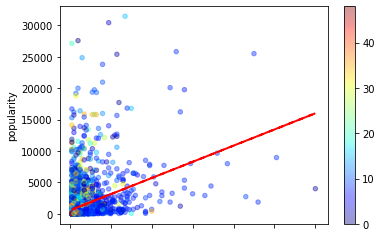

In [37]:
# scatterplot between popularity and degree
popularity_degree_df.plot(kind='scatter', x='degree', y='popularity', alpha=0.4, c=popularity_degree_df['community'], cmap=plt.get_cmap('jet'), colorbar=True)
# add line of best fit to plot
gradient, intercept = np.polyfit(np.array(popularity_degree_df['degree'], dtype=float), np.array(popularity_degree_df['popularity'], dtype=float), 1)
plt.plot(popularity_degree_df['degree'], gradient * popularity_degree_df['degree'] + intercept, color='red', linestyle='--', linewidth=2)

We can clearly see that there is a positive correlation between the artist's degree in the network and their popularity. We cannot definitively determine whether one causes another, but one possible conclusion is that an artist that collaborates with other artists more (and has a higher degree) will have a higher popularity amongst fans as their songs would reach out to wider audiences.